# Implementing and training a Detection Transformer (DETR)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import ops


# Import the custom COCO dataset loader
from dataloaders.coco_od_pytorch import TorchCOCOLoader, collate_fn
from models.detr import DETR

/home/dimitris/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Set the experiment configurations

In [2]:
# Batch size for dataloaders and image size for model/pre-processing
BATCH_SIZE = 4
IMAGE_SIZE = 480
MAX_OBJECTS = 100
FREEZE_BACKBONE = True
EPOCHS = 150
LOG_FREQUENCY = 5 # Training-time losses will be logged according to this frequency
SAVE_FREQUENCY = 20 # Model weights will be saved according to this frequency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Training device

## Create a PyTorch Dataloader

In [3]:
# Class labels for your custom dataset
CLASSES = ["N/A", "chess_piece"]
EMPTY_CLASS_ID = 0 # ID of the dataset classes to treat as "empty" class

# NOTE: You can instead load the COCO CLASSES if you wish to train on the COCO dataset
#       by importing "from datasets.info import DATASET_CLASSES". This
#       is a lookup dictionary in the format:
#       DATASET_CLASSES = {
#           "coco" : {
#               "class_names" : COCO_CLASSES,
#               "empty_class_id": 91,
#               "links":{
#                    "images": "http://images.cocodataset.org/zips/train2017.zip",
#                    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
#           }
#           ....
#       }
# So then you can set "CLASSES" = DATASET_CLASSES["coco"]["class_names"] and "EMPTY_CLASS_ID" = DATASET_CLASSES["coco"]["empty_class_id"]


# Load and COCO dataset (adjust the paths accordingly)
coco_ds_train = TorchCOCOLoader(
    '../data/chess_pieces/train',
    '../data/chess_pieces/train/_annotations.coco.json',
    max_boxes=MAX_OBJECTS,
    empty_class_id=EMPTY_CLASS_ID,
    image_size=IMAGE_SIZE,
    augment=True
)

coco_ds_val = TorchCOCOLoader(
    '../data/chess_pieces/valid',
    '../data/chess_pieces/valid/_annotations.coco.json',
    max_boxes=MAX_OBJECTS,
    empty_class_id=EMPTY_CLASS_ID,
    image_size=IMAGE_SIZE,
)

train_loader = DataLoader(
    coco_ds_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_loader = DataLoader(
    coco_ds_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

print(f"Training dataset size: {len(coco_ds_train)}")
print(f"Validation dataset size: {len(coco_ds_val)}")

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Training dataset size: 606
Validation dataset size: 58


## Plot some samples

t_cl: torch.Size([100]), t_bbox: torch.Size([100, 4]), mask: torch.Size([100])
t_cl: torch.Size([100]), t_bbox: torch.Size([100, 4]), mask: torch.Size([100])
t_cl: torch.Size([100]), t_bbox: torch.Size([100, 4]), mask: torch.Size([100])
t_cl: torch.Size([100]), t_bbox: torch.Size([100, 4]), mask: torch.Size([100])


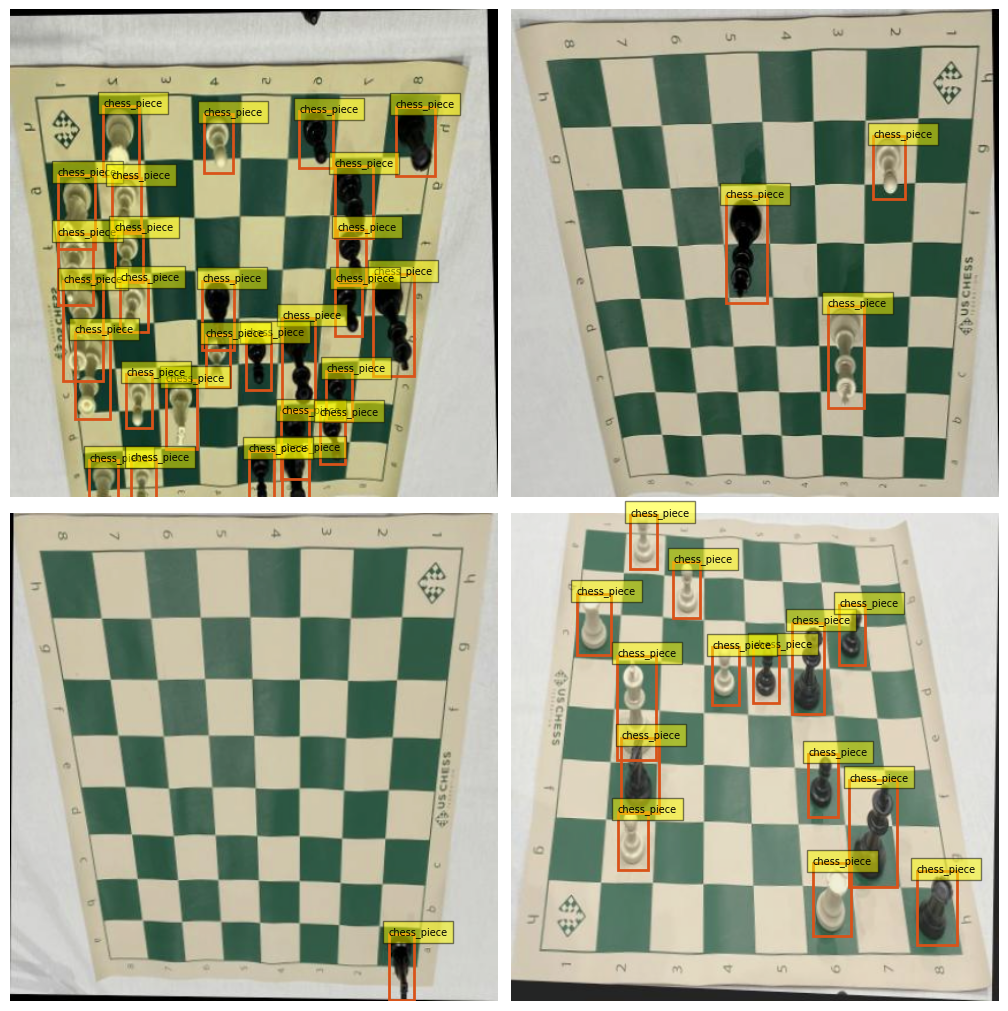

In [ ]:
import matplotlib.pyplot as plt
from utils.visualizers import DETRBoxVisualizer

# Create a visualizer
visualizer = DETRBoxVisualizer(class_labels= CLASSES,
                               empty_class_id=0)

# Visualize batches
dataloader_iter = iter(train_loader)
for i in range(1):
    input_, (classes, boxes, masks, _) = next(dataloader_iter)
    fig = plt.figure(figsize=(10, 10), constrained_layout=True)

    for ix in range(4):
        t_cl = classes[ix]
        t_bbox = boxes[ix]
        mask = masks[ix].bool()

        # Filter padded classes/boxes using the binary mask...
        t_cl = t_cl[mask]
        t_bbox = t_bbox[mask] * IMAGE_SIZE

        # Convert to x1y1x2y2 for visualization and denormalize boxes..
        t_bbox = ops.box_convert(
            t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        
        im = input_[ix]

        ax = fig.add_subplot(2, 2, ix+1)
        visualizer._visualize_image(im, t_bbox, t_cl, ax=ax)

## Building the DETR model

**Note**: If you decide to start from pre-trained weights the `n_classes` argument should
match the number of classes the pre-trained model was trained on (e.g. if trained on "COCO" then it should be 92 classes).

In [ ]:
# We do instantiate the model with the COCO dataset parameters in order to load pre-trained weights
# to fine-tune on a new dataset with...
detr_model = DETR(
    d_model=256, n_classes=92, n_tokens=225, 
    n_layers=6, n_heads=8, n_queries=MAX_OBJECTS
)

## Load pre-trained weights as a starting point to explore Transfer Learning (optional)

Using pre-trained weights can significantly speed up training as the model doesn't start from 0.

Training DETR from scratch might take significant time even with enough GPU horsepower, while with
fine-tuning you can get somewhat decent results with 100-150 epochs depending on your dataset size.

In [ ]:
CHECKPOINT_PATH = "<YOUR_DETR_WEIGHTS.pt>"

# Load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))

# Load the weights into the model
print(detr_model.load_state_dict(checkpoint['state']))

# Adapt the class prediction head to our new dataset
detr_model.linear_class = nn.Linear(detr_model.linear_class.in_features, len(CLASSES))

## Start the training

In [ ]:
from models.trainer import DETRTrainer

# Create a trainer for DETR
trainer = DETRTrainer(model = detr_model,
                      train_loader= train_loader,
                      val_loader=val_loader,
                      device=device,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      log_freq=5,
                      save_freq=SAVE_FREQUENCY,
                      freeze_backbone= FREEZE_BACKBONE,
                      num_queries=MAX_OBJECTS,
                      empty_class_id=EMPTY_CLASS_ID)

# Start the training
trainer.train()

## Plot the training metrics and save the plots

In [ ]:
trainer.visualize_losses(save_dir = "./")

## Load fine-tuned model and test inference

In [ ]:
from utils.visualizers import DETRBoxVisualizer

WEIGHS_PATH = "../weights/chess_100.pt"
INFERENCE_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Trained on your custom dataset
detr_model = DETR(
    d_model=256, n_classes=len(CLASSES), n_tokens=225, 
    n_layers=6, n_heads=8, n_queries=MAX_OBJECTS
).to(INFERENCE_DEVICE)

# Load the checkpoint
print(detr_model.load_state_dict(torch.load(WEIGHS_PATH, map_location=torch.device(INFERENCE_DEVICE))))

# Run inference and check results
visualizer = DETRBoxVisualizer(class_labels= CLASSES,
                               empty_class_id=EMPTY_CLASS_ID)

# This will always run inference on a GPU if one is available...
visualizer.visualize_validation_inference(detr_model, coco_ds_val, collate_fn=collate_fn, batch_size=2)

## Or run inference on a video

In [ ]:
visualizer.visualize_video_inference(
    model=detr_model,
    video_path="<YOUR_VIDEO_PATH>",
    save_dir= "<YOUR_SAVE_DIR>",
    image_size=480,
    batch_size=3,
    nms_threshold=0.5
)

## Evaluate the trained model using the COCO API

In [ ]:
from models.evaluator import DETREvaluator

evaluator = DETREvaluator(detr_model, coco_ds_val, device, EMPTY_CLASS_ID, collate_fn, batch_size=4)
stats = evaluator.evaluate()